<a href="https://colab.research.google.com/github/computablee/DS-5899-CS-5260-Final-Project/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [2]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

sz = train_images.shape[1]
nclassout = 10

train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

In [3]:
def relu_bn(inputs):
    relu = layers.ReLU()(inputs)
    bn = layers.BatchNormalization()(relu)
    return bn

In [4]:
def residual_block(x, downsample, filters, kernel_size = 3):
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=(1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = layers.Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)

    out = layers.Add()([x, y])
    out = relu_bn(out)
    return out

In [11]:
def create_res_net():
    inputs = layers.Input(shape=(sz, sz, 1))
    resize = layers.Resizing(224, 224)(inputs)
    num_filters = 16
    kernel_size = 26
    
    t = layers.BatchNormalization()(resize)
    t = layers.Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [3, 2, 1]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, kernel_size=kernel_size, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
        kernel_size = int(np.floor(kernel_size / 2))
    
    t = layers.AveragePooling2D(4)(t)
    t = layers.Flatten()(t)
    outputs = layers.Dense(10, activation='softmax')(t)
    
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

convnet = create_res_net()
convepochs = 10

In [13]:
history = convnet.fit(train_images, train_labels_onehot, verbose=True, validation_split=.1, epochs=convepochs, batch_size=256)

Epoch 1/10
211/211 [==============================] - 222s 982ms/step - loss: 0.2364 - accuracy: 0.9274 - val_loss: 2.8214 - val_accuracy: 0.6935
Epoch 2/10
211/211 [==============================] - 170s 804ms/step - loss: 0.0734 - accuracy: 0.9787 - val_loss: 0.1032 - val_accuracy: 0.9790
Epoch 3/10
211/211 [==============================] - 170s 805ms/step - loss: 0.0597 - accuracy: 0.9835 - val_loss: 0.1026 - val_accuracy: 0.9783
Epoch 4/10
211/211 [==============================] - 170s 805ms/step - loss: 0.0514 - accuracy: 0.9863 - val_loss: 0.0834 - val_accuracy: 0.9805
Epoch 5/10
211/211 [==============================] - 170s 805ms/step - loss: 0.0475 - accuracy: 0.9866 - val_loss: 0.1084 - val_accuracy: 0.9777
Epoch 6/10
211/211 [==============================] - 170s 805ms/step - loss: 0.0416 - accuracy: 0.9881 - val_loss: 0.0892 - val_accuracy: 0.9817
Epoch 7/10
211/211 [==============================] - 170s 805ms/step - loss: 0.0349 - accuracy: 0.9899 - val_loss: 0.0680 -

In [15]:
def plot_loss(epochs, loss, val_loss):
    ep_titles = list(range(1, epochs + 1))
    ep_ticks = list(range(1, epochs + 1))
    
    plt.plot(ep_titles, loss, label="loss")
    plt.plot(ep_titles, val_loss, label="val_loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.suptitle("Loss as a Function of Epoch")
    plt.xticks(ep_ticks)
    plt.show()
    

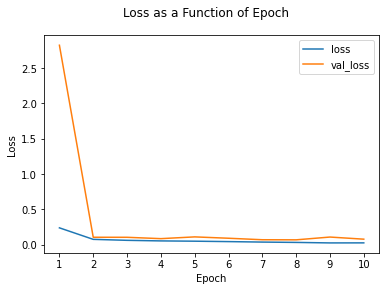

313/313 [==============================] - 11s 30ms/step - loss: 0.0588 - accuracy: 0.9864
Accuracy:  0.9864000082015991


In [16]:
plot_loss(convepochs, history.history['loss'], history.history['val_loss'])

evaluation = convnet.evaluate(test_images, test_labels_onehot)
print("Accuracy: ", str(evaluation[1]))


In [18]:
convnet.save('./mnist_convnet.hdf5')

In [17]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(convnet.trainable_weights)
non_trainable_count = count_params(convnet.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 2,005,982
Trainable params: 2,005,244
Non-trainable params: 738
